# Streaming & Exploring Muse 2 EEG

## Intro
This notebook converts raw Muse 2 EEG signals into features for my NeuroAI project. Data flows from Bluetooth stream → CSV/raw buffers → band-power features (δ/θ/α/β/γ). These features will support downstream tasks such as state detection, biofeedback, and interactive visualizations.

## Data streams (Muse 2)
* EEG: TP9, AF7, AF8, TP10 (RightAUX optional)
* Motion: Accelerometer, Gyroscope
* Physio: PPG/Heart rate (device/firmware dependent)

## Workflow
* Connect Muse 2 via Bluetooth
* Stream and record raw signals
* Preprocess (detrend, notch, bandpass)
* Extract band-power features
* Save outputs for ML models

## Prereqs
* Python 3.9+
* muselsl 
* numpy, scipy, pandas, mne, matplotlib
* Stable Muse 2 Bluetooth connection

### Setup env

In [80]:
# Install muselsl
# !pip install muselsl

# Install brainflow (optional, if you want more control)
# !pip install brainflow


### Imports

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
from scipy import stats

### Load and Clean all CSVs

In [47]:
DATA_DIR = Path("data")

EEG_SITES = ["tp9","af7","af8","tp10"]
BANDS = ["delta","theta","alpha","beta","gamma"]

In [48]:
def get_songname_from_filename(path: Path) -> str:
    """
    Extract song name from filename
    """
    stem = path.stem
    parts = stem.split("-", 1)
    song_parts = parts[0].split("_by_")
    song = song_parts[0]
    artist = song_parts[1]
    return song


In [49]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    # Normalize names
    df.columns = [re.sub(r"_+", "_", c.lower().strip().replace(" ", "_")) for c in df.columns]

    # Timestamp index if present
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
        df = df.dropna(subset=["timestamp"]).sort_values("timestamp").set_index("timestamp")

    # Coerce numerics 
    for c in df.columns:
        if c != "elements":
            df[c] = pd.to_numeric(df[c], errors="ignore")

    # Drop duplicate timestamps
    if isinstance(df.index, pd.DatetimeIndex):
        df = df[~df.index.duplicated(keep="first")]

    # Fill/interpolate numeric cols to smooth tiny gaps
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols):
        df[num_cols] = df[num_cols].ffill(limit=5)
        if isinstance(df.index, pd.DatetimeIndex):
            df[num_cols] = df[num_cols].interpolate(method="time", limit=10, limit_direction="both")
        else:
            df[num_cols] = df[num_cols].interpolate(limit=10, limit_direction="both")

    return df

In [50]:
def add_band_means_and_indices(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Per-band means across electrodes (alpha_mean, etc.)
    for band in BANDS:
        cols = [f"{band}_{s}" for s in EEG_SITES if f"{band}_{s}" in out.columns]
        if cols:
            out[f"{band}_mean"] = out[cols].mean(axis=1)

    # Ratios & indices
    if {"alpha_mean","beta_mean"}.issubset(out.columns):
        out["alpha_beta_ratio"] = out["alpha_mean"] / (out["beta_mean"] + 1e-9)

    if {"beta_mean","alpha_mean","theta_mean"}.issubset(out.columns):
        out["engagement_idx"] = out["beta_mean"] / (out["alpha_mean"] + out["theta_mean"] + 1e-9)
        out["relaxation_idx"] = out["alpha_mean"] / (out["theta_mean"] + 1e-9)

    return out

### Load and Clean all CSVs, add song labels

In [51]:
all_dfs = []
for f in DATA_DIR.glob("*.csv"):
    song = get_songname_from_filename(f)
    df = pd.read_csv(f)
    df = clean_df(df)
    df = add_band_means_and_indices(df)
    df["song"] = song
    df["file"] = f.name
    all_dfs.append(df)

assert all_dfs, "No CSVs found in data/"

big = pd.concat(all_dfs, axis=0, ignore_index=False)  # keep timestamp index if present
big.head()


/var/folders/2j/2b2ygyfx2x7g2td9nt_33ghw0000gn/T/ipykernel_23185/548574125.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
/var/folders/2j/2b2ygyfx2x7g2td9nt_33ghw0000gn/T/ipykernel_23185/548574125.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
/var/folders/2j/2b2ygyfx2x7g2td9nt_33ghw0000gn/T/ipykernel_23185/548574125.py:13: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
/var/folders/2j/2b2ygyfx2x7g2td9nt_33ghw0000gn/T/ipykernel_23185/548574125.py:13: FutureWarning: errors='ignore' is deprecated 

,delta_tp9,delta_af7,delta_af8,delta_tp10,theta_tp9,theta_af7,theta_af8,theta_tp10,alpha_tp9,alpha_af7,...,delta_mean,theta_mean,alpha_mean,beta_mean,gamma_mean,alpha_beta_ratio,engagement_idx,relaxation_idx,song,file
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-09-08 17:40:47.388000+00:00,0.910783,1.278719,0.956191,0.851393,1.285112,0.882651,0.737912,0.516362,0.714752,0.852208,...,0.999272,0.855509,0.719677,0.528291,0.031451,1.362273,0.335383,0.841226,bulgarian_eternal_funk,bulgarian_eternal_funk_by_eternxlk-2025-09-08-...
2025-09-08 17:40:47.430000+00:00,0.910783,1.278719,0.956191,0.851393,1.285112,0.882651,0.737912,0.516362,0.714752,0.852208,...,0.999272,0.855509,0.719677,0.528291,0.031451,1.362273,0.335383,0.841226,bulgarian_eternal_funk,bulgarian_eternal_funk_by_eternxlk-2025-09-08-...
2025-09-08 17:40:47.487000+00:00,0.910783,1.278719,0.956191,0.851393,1.285112,0.882651,0.737912,0.516362,0.714752,0.852208,...,0.999272,0.855509,0.719677,0.528291,0.031451,1.362273,0.335383,0.841226,bulgarian_eternal_funk,bulgarian_eternal_funk_by_eternxlk-2025-09-08-...
2025-09-08 17:40:48.393000+00:00,0.910783,1.278719,0.956191,0.851393,1.285112,0.882651,0.737912,0.516362,0.714752,0.852208,...,0.999272,0.855509,0.719677,0.528291,0.031451,1.362273,0.335383,0.841226,bulgarian_eternal_funk,bulgarian_eternal_funk_by_eternxlk-2025-09-08-...
2025-09-08 17:40:48.890000+00:00,0.910783,1.278719,0.956191,0.851393,1.285112,0.882651,0.737912,0.516362,0.714752,0.852208,...,0.999272,0.855509,0.719677,0.528291,0.031451,1.362273,0.335383,0.841226,bulgarian_eternal_funk,bulgarian_eternal_funk_by_eternxlk-2025-09-08-...


In [58]:
df.columns

Index(['delta_tp9', 'delta_af7', 'delta_af8', 'delta_tp10', 'theta_tp9',
       'theta_af7', 'theta_af8', 'theta_tp10', 'alpha_tp9', 'alpha_af7',
       'alpha_af8', 'alpha_tp10', 'beta_tp9', 'beta_af7', 'beta_af8',
       'beta_tp10', 'gamma_tp9', 'gamma_af7', 'gamma_af8', 'gamma_tp10',
       'raw_tp9', 'raw_af7', 'raw_af8', 'raw_tp10', 'aux_right',
       'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyro_x',
       'gyro_y', 'gyro_z', 'ppg_ambient', 'ppg_ir', 'ppg_red', 'heart_rate',
       'headbandon', 'hsi_tp9', 'hsi_af7', 'hsi_af8', 'hsi_tp10', 'battery',
       'elements', 'delta_mean', 'theta_mean', 'alpha_mean', 'beta_mean',
       'gamma_mean', 'alpha_beta_ratio', 'engagement_idx', 'relaxation_idx',
       'song', 'file'],
      dtype='object')

In [52]:
song_summary = (big
    .groupby("song")
    .agg({
        "alpha_mean":"mean",
        "beta_mean":"mean",
        "theta_mean":"mean",
        "gamma_mean":"mean",
        "alpha_beta_ratio":"mean",
        "engagement_idx":"mean",
        "relaxation_idx":"mean",
        "heart_rate":"mean" if "heart_rate" in big.columns else "mean"
    })
    .rename(columns={"heart_rate":"heart_rate_mean"})
    .sort_index()
)

song_summary

,alpha_mean,beta_mean,theta_mean,gamma_mean,alpha_beta_ratio,engagement_idx,relaxation_idx,heart_rate_mean
song,,,,,,,,
aleph,0.946196,0.607614,0.611535,0.083430,1.595378,0.393215,1.571360,83.255005
bulgarian_eternal_funk,0.869423,0.391455,0.621211,-0.185108,2.295116,0.263573,1.441030,83.408741
frequency,0.955808,0.625599,0.551787,0.171912,1.551088,0.418282,1.798718,82.829926
nature_sounds,0.876195,0.326268,0.616753,-0.184873,2.918081,0.224348,1.474607,83.338314
walkway_blues,0.752278,0.325983,0.519886,-0.199018,2.359953,0.258926,1.493503,86.501681
your_idol,0.834838,0.627351,0.581299,0.218263,1.359573,0.455502,1.482410,82.803298


### First I'll rank Alpha (relaxation/meditative)

In [67]:
rank_alpha = song_summary.sort_values("alpha_mean", ascending=False)[["alpha_mean"]]
print("Top by alpha_mean (relaxation):")
display(rank_alpha)

Top by alpha_mean (relaxation):


,alpha_mean
song,
frequency,0.955808
aleph,0.946196
nature_sounds,0.876195
bulgarian_eternal_funk,0.869423
your_idol,0.834838
walkway_blues,0.752278


### Next, we'll rank Beta (low arousal)

In [65]:
rank_beta  = song_summary.sort_values("beta_mean", ascending=True)[["beta_mean"]]
print("\nTop by lowest beta_mean (low effort):")
display(rank_beta)


Top by lowest beta_mean (low effort):


,beta_mean
song,
walkway_blues,0.325983
nature_sounds,0.326268
bulgarian_eternal_funk,0.391455
aleph,0.607614
frequency,0.625599
your_idol,0.627351


In [64]:
rank_ratio = song_summary.sort_values("alpha_beta_ratio", ascending=False)[["alpha_beta_ratio"]]

print("\nTop by alpha/beta ratio:")
display(rank_ratio)


Top by alpha/beta ratio:


,alpha_beta_ratio
song,
nature_sounds,2.918081
walkway_blues,2.359953
bulgarian_eternal_funk,2.295116
aleph,1.595378
frequency,1.551088
your_idol,1.359573


### What this suggests
* Nature sounds consistently scores as the most “relaxing” across multiple indices (high alpha, low beta, highest α/β ratio).
* Frequency and aleph are alpha-heavy but still carry more beta, so maybe they’re calming and gently engaging.
* Walkway blues is low-beta (soothing) but not as alpha-boosting as the top two, giving it a slightly different signature.
* Your idol consistently ranks lowest on these indices → potentially more stimulating or arousing.

### Next let's rank by Theta (deep calm/creativity)

In [68]:
rank_theta = song_summary.sort_values("theta_mean", ascending=False)[["theta_mean"]]
rank_theta

,theta_mean
song,
bulgarian_eternal_funk,0.621211
nature_sounds,0.616753
aleph,0.611535
your_idol,0.581299
frequency,0.551787
walkway_blues,0.519886


### Rank Gamma (sensory/processing)

In [69]:
rank_gamma = song_summary.sort_values("gamma_mean", ascending=False)[["gamma_mean"]]
display(rank_gamma)

,gamma_mean
song,
your_idol,0.218263
frequency,0.171912
aleph,0.083430
nature_sounds,-0.184873
bulgarian_eternal_funk,-0.185108
walkway_blues,-0.199018


### Heart Rate (body relaxation)

In [70]:
rank_hr = song_summary.sort_values("heart_rate_mean", ascending=True)[["heart_rate_mean"]]
print("Lower HR = calmer physiological response")
display(rank_hr)

Lower HR = calmer physiological response


,heart_rate_mean
song,
your_idol,82.803298
frequency,82.829926
aleph,83.255005
nature_sounds,83.338314
bulgarian_eternal_funk,83.408741
walkway_blues,86.501681


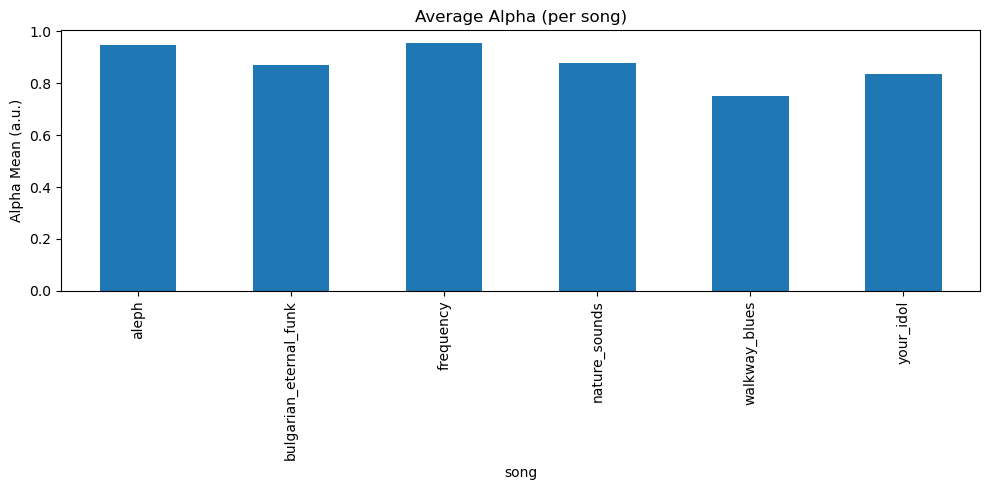

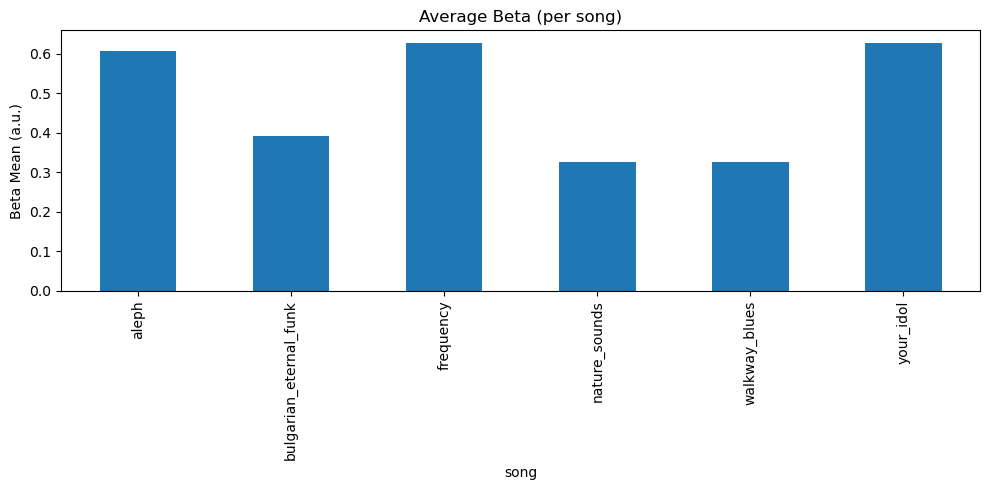

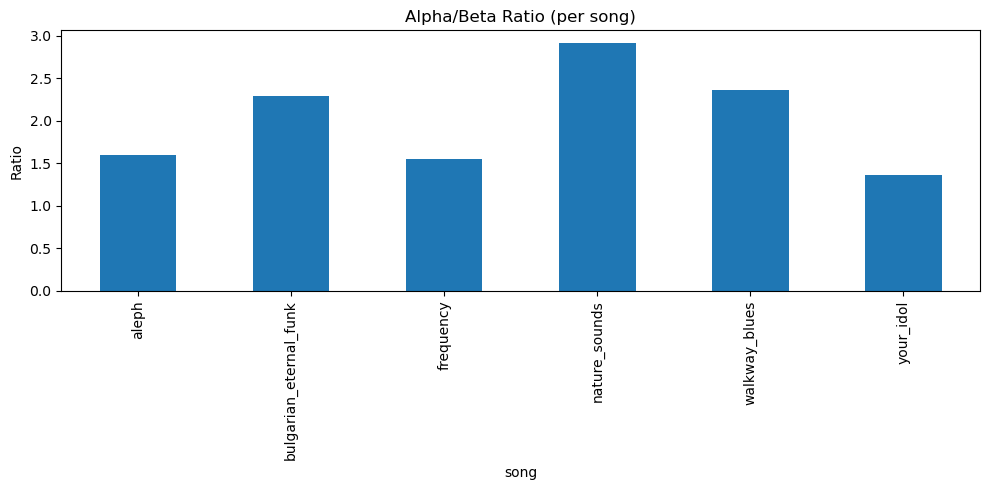

In [54]:
plt.figure(figsize=(10,5))
song_summary["alpha_mean"].plot(kind="bar")
plt.title("Average Alpha (per song)")
plt.ylabel("Alpha Mean (a.u.)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
song_summary["beta_mean"].plot(kind="bar")
plt.title("Average Beta (per song)")
plt.ylabel("Beta Mean (a.u.)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
song_summary["alpha_beta_ratio"].plot(kind="bar")
plt.title("Alpha/Beta Ratio (per song)")
plt.ylabel("Ratio")
plt.tight_layout()
plt.show()


### One-way ANOVA on alpha_mean
Test whether the mean alpha power (alpha_mean) differs significantly across songs.

In [55]:
alpha_by_song = [grp["alpha_mean"].dropna().values for _, grp in big.groupby("song")]
alpha_by_song = [x for x in alpha_by_song if len(x) > 2]  # need some samples

if len(alpha_by_song) >= 2:
    fval, pval = stats.f_oneway(*alpha_by_song)
    print(f"One-way ANOVA on alpha_mean across songs: F={fval:.3f}, p={pval:.3e}")
else:
    print("Not enough groups/samples for ANOVA.")


One-way ANOVA on alpha_mean across songs: F=79.554, p=1.488e-73


### Kruskal-Wallis on alpha_mean
Again, check whether the distributions of alpha_mean differ across songs. 

alpha_by_song = [grp["alpha_mean"].dropna().values for _, grp in big.groupby("song")]
alpha_by_song = [x for x in alpha_by_song if len(x) > 2]

if len(alpha_by_song) >= 2:
    hval, pval = stats.kruskal(*alpha_by_song)
    print(f"Kruskal–Wallis on alpha_mean across songs: H={hval:.3f}, p={pval:.3e}")
else:
    print("Not enough groups/samples for Kruskal–Wallis.")


### Conclusion: 
Both ANOVA and Kruskal-Wallis show that songs produce highly distinct alpha responses.

### Dimensionality reduction (PCA, t-SNE):
I'll plot all songs in 2D space to see which cluster together in terms of brain+body response.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Principal Component Analysis (PCA)

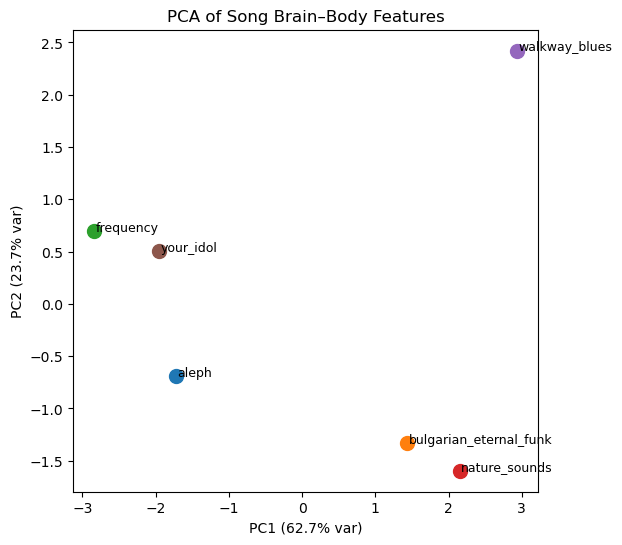

In [73]:
feat_cols = [
    "alpha_mean","beta_mean","theta_mean","gamma_mean",
    "heart_rate_mean","alpha_beta_ratio","engagement_idx","relaxation_idx"
]

feat_df = song_summary[feat_cols].dropna().copy()
songs = feat_df.index.tolist()

# Standardize features
X = StandardScaler().fit_transform(feat_df.values)

# ---- PCA ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
for (x,y), label in zip(X_pca, songs):
    plt.scatter(x, y, s=100)
    plt.text(x+0.02, y, label, fontsize=9)
plt.title("PCA of Song Brain–Body Features")
plt.xlabel("PC1 (%.1f%% var)" % (pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 (%.1f%% var)" % (pca.explained_variance_ratio_[1]*100))
plt.show()

### Interpretation:
* Songs are fairly well separated → they evoke distinct brain–body profiles.
* frequency and your_idol cluster together → similar neural state.
* nature_sounds and bulgarian_eternal_funk cluster together → another similar response group.
* walkway_blues is an outlier → unique signature.

### t-distributed Stochastic Neighbor Embedding (t-SNE)

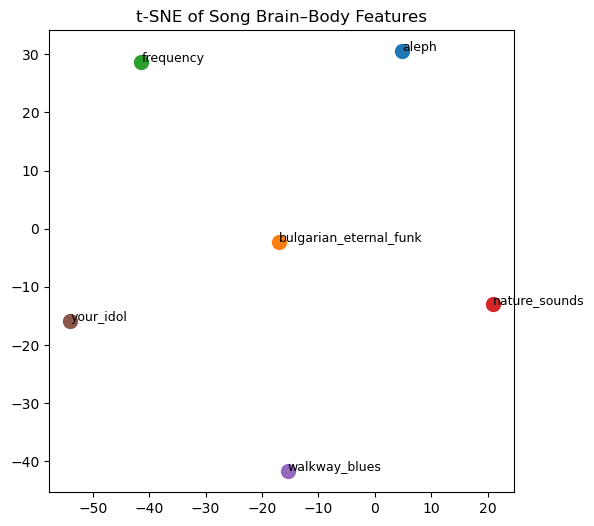

In [74]:
X_tsne = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(X)

plt.figure(figsize=(6,6))
for (x,y), label in zip(X_tsne, songs):
    plt.scatter(x, y, s=100)
    plt.text(x+0.02, y, label, fontsize=9)
plt.title("t-SNE of Song Brain–Body Features")
plt.show()

### Interpretation
* frequency and aleph both high on Y axis, but separated left/right → showing they’re distinct, though somewhat similar in structure.
* nature_sounds and bulgarian_eternal_funk sit closer together → cluster of calming, balanced tracks.
* your_idol sits off on its own → distinct state.
* walkway_blues is far at the bottom → again an outlier, clearly separated from all others.